In [1]:
# Import Modules
import numpy as np 
import statsmodels.api as sm
import pyprimes
import matplotlib.pyplot as plt
import seaborn as sns

# Import Functions
from mpmath import zeta
from scipy.stats import gumbel_r, linregress 
from scipy.interpolate import interp1d, UnivariateSpline
from time import time 

In [2]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
# Loading in Cython (C wrapper)
%load_ext Cython

## <h1><center> NUMERICAL STUDY OF THE LARGE VALUES OF THE RIEMANN ZETA FUNCTION SUPERVISED BY PROF. L.P. ARGUIN </center></h1>

**Objectives The goal is to develop numerical methods to verify and extend conjectures about the large values of the Riemann zeta function in short intervals. The [Riemann Zeta](https://en.wikipedia.org/wiki/Riemann_zeta_function) function is defined as:**

$$\zeta(s):=\sum_{n=1}^\infty{n^{-s}} \ \ \ \ : \ (s=\sigma + it) \ \ ; \ (\sigma > 1)$$

In [4]:
%%cython
cimport numpy as nc

import pyximport
pyximport.install(pyimport=True)

from mpmath import zeta
from numpy import zeros, array

def zetaNormRange(int N , int deltaN) -> nc.ndarray:
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param N: Provide a number (presumably large) to start computing values for
    :param deltaN: Provide an integer number to cap off the consecutive sums of prime
    :return: Returns an array of the normalized values for Zeta 
    """
    cdef nc.complex128_t point = complex(0, 0)
    cdef nc.complex128_t zeta_value = point
    cdef int t = N

    # storage for the normal zeta 
    cdef nc.ndarray zeta_array = zeros(shape=deltaN+1)
    
    # computing the Zeta function over a small interval defined by deltaN
    for t in range(N, N+deltaN+1):
        point = complex(real=0.5, imag=t)
  
        # computes the normalized zeta function -> refer to absoulte value code 
        zeta_array[t-N] = abs(zeta(point))

    return zeta_array

In [5]:
N = 0           # starting value of T range 
deltaN = 500    # length of T range

In [6]:
# creating the interval range t
t_range=np.arange(N, N+deltaN+1)

In [7]:
# storage for the normal zeta 
norm_zeta_value = zetaNormRange(N, deltaN)

# rolling average of norm function 
average = np.cumsum(norm_zeta_value)/(t_range+1)

# rolling maximum of norm function
maximum = [norm_zeta_value[:i+1].max() for i in range(norm_zeta_value.size)]

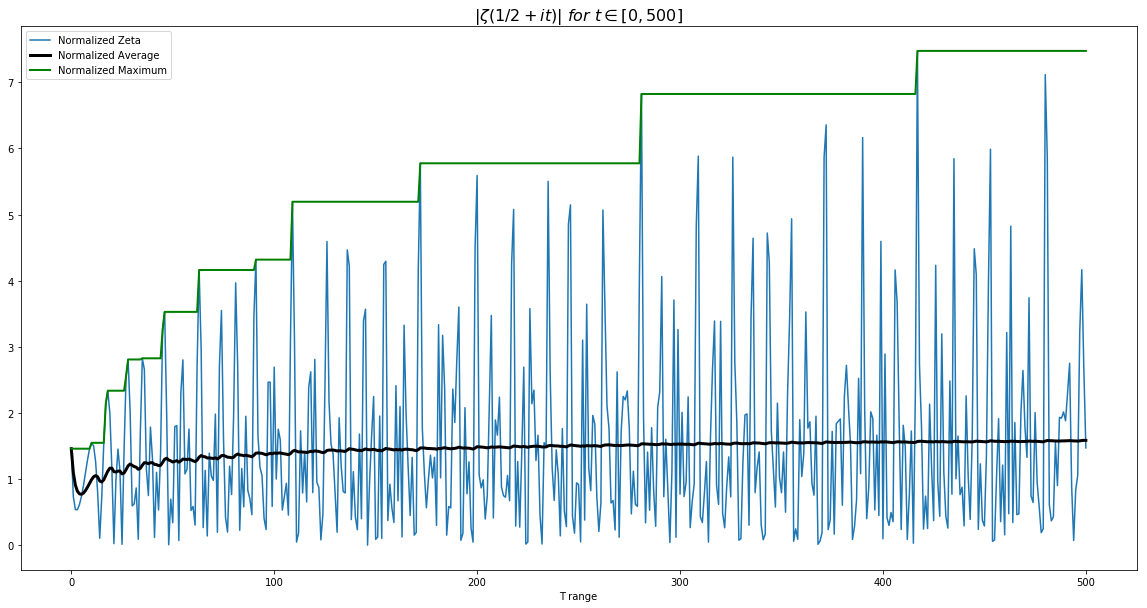

In [8]:
plt.figure(figsize=(20,10))  
plt.title('$|\zeta(1/2 + it)| \ for \ t\in [{},{}]$'.format(N, N+deltaN), size=16)
plt.plot(t_range, norm_zeta_value, label='Normalized Zeta')
plt.plot(t_range, average, label='Normalized Average', lw=3, color='black')
plt.plot(t_range, maximum, label='Normalized Maximum', lw=2, color='green')
plt.xlabel('T range')
plt.legend()
plt.show()

### A model for large values of $log(\zeta)$

Our Zeta Stochastic Function is defined $(\ X_T(h),\  h\in I)$, with $I\in [-1,1]$
$$X_T(h) = \sum_{p\leq T}\cdot \frac{1}{\sqrt{p}}Re(p^{ih}e^{i\theta_p})$$
Where $p$ refers to the primes, $Re$ is concerned with the 'real' part of the expression $p^{ih}e^{i\theta_p}$ and $\theta_p \sim U(0,2\pi) \ IID$ and indexed by primes

Through Euler's method we have the following realization
$$X_T(h) = \sum_{p\leq T}\cdot \frac{1}{\sqrt{p}}cos(\theta_p - hlog(p))$$

In [9]:
# Reading in a Prime list

try:
    # ideally prime numbers should be calculated externally or stored in a txt file
    print('File found, returning prime list...')
    text_file = open("prime.txt", "r")
    prime_num = np.array(list(map(lambda x: int(x), text_file.read().split(',')[:-1])))
    print("Primes returned up to", prime_num[-1])
    
except FileNotFoundError:
    print('File not found, generating prime list...')
    
    # Stores prime list up to 10^8 (ideally should hold 10^50)
    prime_num = np.array(list(pyprimes.primes_below(1e8)))
    
    # store the prime number list in a text file (temporary)
    f = open("prime.txt", "w")
    for i in prime_num:
        f.write("{},".format(str(i)))
    f.close()
    
    text_file = open("prime.txt", "r")
    prime_num = np.array(list(map(lambda x: int(x), text_file.read().split(',')[:-1])))
    print("Primes returned up to", prime_num[-1])

File found, returning prime list...
Primes returned up to 99999989


In [67]:
# author: Bruno Astrolino E Silva (a.k.a Robert William Hanks)
# https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n/3035188#3035188
def primesfrom2to(n:int) -> np.array:
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=np.bool)
    for i in range(1,int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[       k*k//3     ::2*k] = False
            sieve[k*(k-2*(i&1)+4)//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0][1:]+1)|1)]

In [70]:
prime_num = primesfrom2to(int(1e12))

array([  2,   3,   5,   7,  11,  13,  17,  19,  23,  29,  31,  37,  41,
        43,  47,  53,  59,  61,  67,  71,  73,  79,  83,  89,  97, 101,
       103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167,
       173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239,
       241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313,
       317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397,
       401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467,
       479, 487, 491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569,
       571, 577, 587, 593, 599, 601, 607, 613, 617, 619, 631, 641, 643,
       647, 653, 659, 661, 673, 677, 683, 691, 701, 709, 719, 727, 733,
       739, 743, 751, 757, 761, 769, 773, 787, 797, 809, 811, 821, 823,
       827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887, 907, 911,
       919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997],
      dtype=int64)

In [71]:
prime_num

array([       2,        3,        5, ..., 99999959, 99999971, 99999989])

In [10]:
%%cython
cimport numpy as nc
from libc.math cimport log, sqrt, pi, cos

import pyximport
pyximport.install(pyimport=True)

from random import uniform

# Model is developed above 
def zetaStochastic(double h, int T, nc.ndarray prime_list) -> double:
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param h: Provide a floating interval range to observe the Zeta function
    :param T: Provide an integer number to cap off the consecutive sum of primes
    :param prime list: Provide an array of prime numbers
    :return: Returns a value for the stochastic Zeta function 
    """
    assert T < int(1e10), 'Our prime list does not exceed the value 10^7'
    
    cdef double ret_val = 0.0
    cdef int p = 0
    cdef double upper = 2 * pi
    
    # filter the primes up to and including the value of T
    cdef nc.ndarray primes = prime_list[prime_list <= T]
    
    # itterate through the primes using the specified model 
    for p in primes: 
        ret_val += 1/sqrt(p) * cos(uniform(0, upper) - h*log(p)) 
        
    return ret_val

In [11]:
# value of T placed at 10^6 (ideally taken should be taken 10^15, 10^25, etc)
T_val = int(1e6)

# create range interval of h from -1 to 1 (points at every 1/log(T))
x=np.arange(-1,1,1/np.round(np.log(T_val)))

In [12]:
x

array([-1.00000000e+00, -9.28571429e-01, -8.57142857e-01, -7.85714286e-01,
       -7.14285714e-01, -6.42857143e-01, -5.71428571e-01, -5.00000000e-01,
       -4.28571429e-01, -3.57142857e-01, -2.85714286e-01, -2.14285714e-01,
       -1.42857143e-01, -7.14285714e-02, -4.44089210e-16,  7.14285714e-02,
        1.42857143e-01,  2.14285714e-01,  2.85714286e-01,  3.57142857e-01,
        4.28571429e-01,  5.00000000e-01,  5.71428571e-01,  6.42857143e-01,
        7.14285714e-01,  7.85714286e-01,  8.57142857e-01,  9.28571429e-01])

In [13]:
# run time complexity of the stochastic zeta function
run_time = np.arange(1, 20, 2)
complexity = []

for s in run_time:
    t1 = time()
    [[zetaStochastic(h=i, T=T_val, prime_list=prime_num) for i in x] for _ in range(s)]
    complexity.append(time() - t1)

In [14]:
np.array(complexity)

array([ 2.62836218,  7.97193289, 13.48816514, 17.82972407, 22.41593051,
       27.07010245, 34.15684772, 38.6925385 , 45.84093022, 47.51455021])

In [15]:
# preform regression on the runtime of the stochastic zeta function
comp_reg_slope = linregress(run_time, complexity).slope 
comp_reg_intercept = linregress(run_time, complexity).intercept 

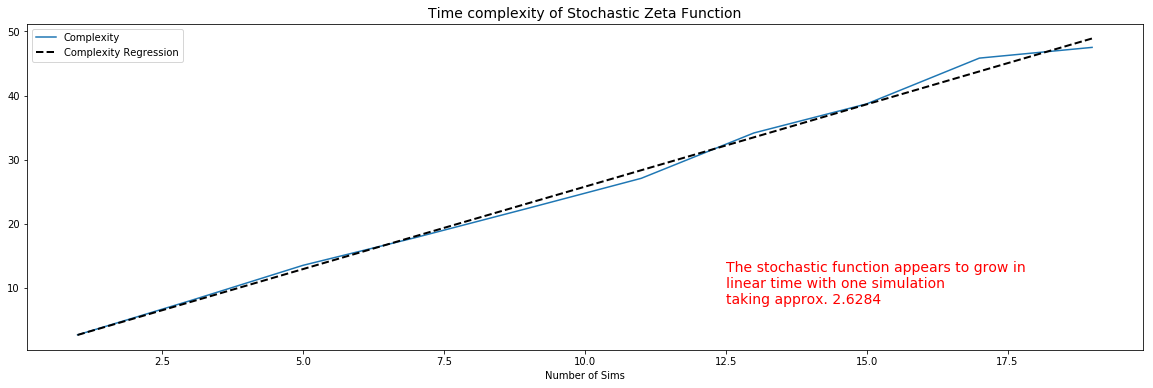

In [16]:
plt.figure(figsize=(20,6))  
plt.title("Time complexity of Stochastic Zeta Function", size=14)
plt.plot(run_time, complexity, label='Complexity')
plt.plot(run_time, [comp_reg_slope*i + comp_reg_intercept for i in range(1,20, 2)], label='Complexity Regression', 
         ls='--', lw=2, color='black')
plt.text(12.5, 7.5, 
         'The stochastic function appears to grow in \nlinear time with one simulation\ntaking approx. {}'.format(round(complexity[0], 4)), 
         size=14, color='red')
plt.xlabel('Number of Sims')
plt.legend()
plt.show()

In [17]:
# create stochastic zeta range over h interval 
sims = 100
y = np.array([[zetaStochastic(h=i, T=T_val, prime_list=prime_num) for i in x] for _ in range(sims)]).reshape(sims, x.size)

In [18]:
y

array([[ 0.8578038 ,  0.78754576, -0.21786914, ...,  0.64116846,
         0.84773552, -2.53668266],
       [ 1.75863071,  1.21372382,  1.20030296, ..., -0.10782302,
         3.82093243,  1.69684532],
       [ 0.09738082, -3.31687967, -2.19048937, ...,  0.27992948,
        -0.75461234, -0.54690681],
       ...,
       [-0.03814683,  0.88537891, -0.75655131, ..., -0.12094857,
        -1.59099374,  1.32741671],
       [ 0.1567564 ,  0.4748479 , -1.48235718, ..., -0.15587353,
         2.40332057, -0.55590265],
       [-0.64960329,  1.43632357,  1.46136508, ...,  0.90743266,
        -0.11996354,  0.39689676]])

In [19]:
# rolling maximum of norm function
# maximum = [y[:, :i+1].max() for i in range(y.shape[1])]

# rolling minimum of norm function
# minimum = [y[:, :i+1].min() for i in range(y.shape[1])]

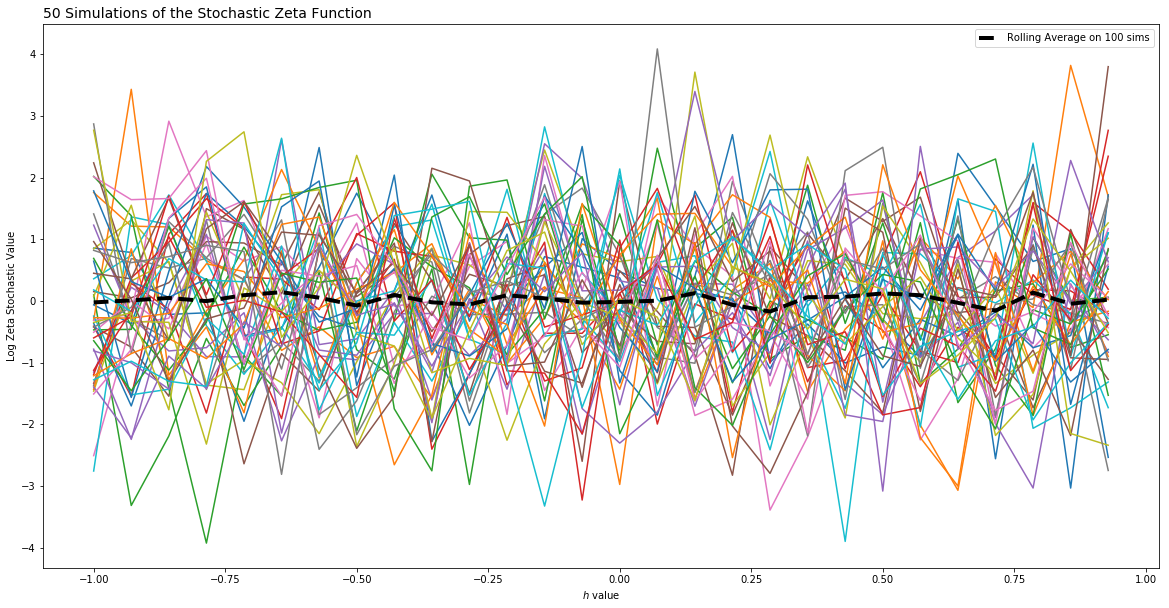

In [20]:
plt.figure(figsize=(20,10))  
plt.title("50 Simulations of the Stochastic Zeta Function", loc='left', size=14)
for i in y[:50]:
    plt.plot(x, i)
plt.plot(x, np.average(y, axis=0), lw=4, color='black', label='Rolling Average on {} sims'.format(sims), ls='--')
# plt.plot(x, maximum, lw=2, color='red', ls='--', label='Rolling Maximum')
# plt.plot(x, minimum, lw=2, color='red', ls='--', label='Rolling Minimum')

plt.ylabel('Log Zeta Stochastic Value')
plt.xlabel('$h$ value')
plt.legend()
plt.show()

**Conjecture**

We assert that the maxium of the stochastic function should be defined as follows:
$$max_{|h|<1}X_t(h)\approx log(log(T)) - \frac{3}{4}log(log(log(T)))$$
Abbreviating the log expressions, we underscore each log with the number of succesive logs taken of the value $T$ below
$$max_{|h|<1}X_t(h)\approx log_2(T)) - \frac{3}{4}log_3(T)))$$
I shall also be exploring the IID instance, where our conjecture converges to the following: 
$$max_{|h|<1}X_t(h)\approx log_2(T)) - \frac{1}{4}log_3(T)))$$

In [21]:
# computes the max of the stochastic zeta function 
stoch_max = lambda x: (np.log(np.log(x)) - 0.75*np.log(np.log(np.log(x))))
stoch_max_iid = lambda x: (np.log(np.log(x)) - 0.25*np.log(np.log(np.log(x))))

In [22]:
cong_stoch_max = stoch_max(T_val)
cong_stoch_max_iid = stoch_max_iid(T_val)

print("Our simulated maximum was        ->", np.average(y.max(axis=1)))
print("Conjecture maximum should be     ->", cong_stoch_max)
print("IID Conjecture maximum should be ->", cong_stoch_max_iid)

Our simulated maximum was        -> 2.417141044303556
Conjecture maximum should be     -> 1.901755015287042
IID Conjecture maximum should be -> 2.3844462814130214


**Function Variation**

To measure the degree of variation expected with the simulation for large values of Zeta, we need to consider extreme statistics for determining the extent of our model's variation. We begin by recentering our stochastic model as follows: 
$$\Theta = max_{|h|<1}X_t(h) - (log_2(T) - \frac{3}{4}log_3(T))$$
We say that our $\Theta$ follows a [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution), defined below
$$P(\Theta < x)=exp(-e^\frac{-(x-\mu)}{\beta})$$ 
$$P(\Theta < x)=exp(-ce^{-2x}) \, \ \ \  \mu = 0 \ , \ \ \beta = \frac{1}{2}$$ 

Our variance measure is then:
$$Var(\Theta)=\frac{\pi^2}{6}\beta^2=\frac{\pi^2}{24}\approx 0.41123$$

Hence, in our case our expression for the maximum of our stochastic process introduces and error term: 
$$log_2(T) - \frac{3}{4}log_3(T) + (Gumbel)$$

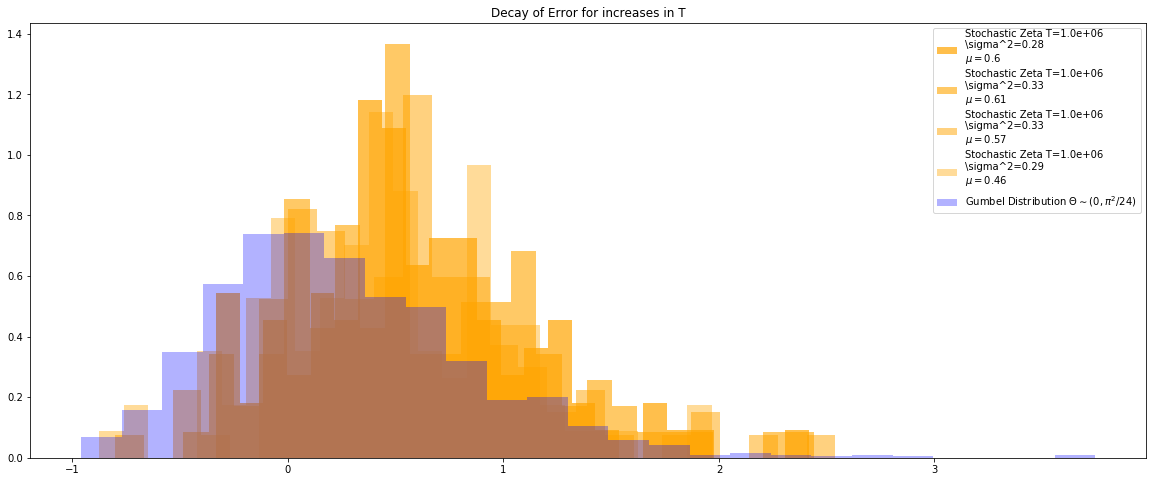

In [62]:
bins = 25
cVar = 0
# gumbel distribution with mean 0 and beta 0.5
gumbel_dist = gumbel_r.rvs(loc=0, scale=0.5, size=1000)
T_stamps = [int(1e3), int(1e4), int(1e5), int(1e6)]
a_term = 0.7

plt.figure(figsize=(20, 8))
plt.title('Decay of Error for increases in T')

# changes in T over time from 10^3 - 10^6
for t in T_stamps:
    temp = np.array([[zetaStochastic(h=i, T=t, prime_list=prime_num) for i in x] for _ in range(sims)]).reshape(sims, x.size)
    error = (temp.max(axis=1)-stoch_max(t))
    
    # computing the variance and average of the function 
    cVar = round(np.var(error), 2)
    average = round(np.average(error),2)
    
    # re-centered normal distrubtion to observe the shape of the hist (variance pi^2/24)
    plt.hist(error, bins=bins, alpha=a_term, color='orange', density=True, 
             label="Stochastic Zeta T={}\n$\sigma^2={}$\n$\mu={}$ ".format('%.1e' % i, cVar, average))
    a_term -= 0.1

plt.hist(gumbel_dist, bins=bins, alpha=0.3, color='blue', 
         label="Gumbel Distribution $(0,1/2)$", density=True)
plt.legend()
plt.show()

For the IID case we have that,
$$\Theta = max_{|h|<1}X_t(h) - (log_2(T) - \frac{1}{4}log_3(T))$$
With error term confined to the Gumbell distribution, with mean $0$ and variance $1/2$. We examine the error distribution in similar fashion as we did with the non-IID case. It appears that the distrubtion's closely centered with minior variations in skew.  

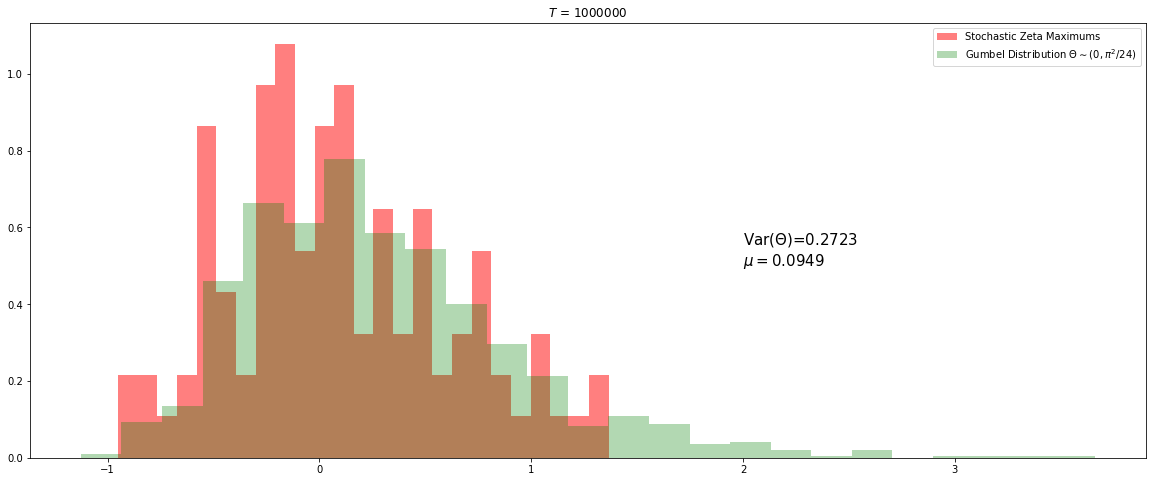

In [24]:
bins = 25
iid_cVar = 0
iid_gumbel_dist = gumbel_r.rvs(loc=0, scale=0.5, size=1000)

iid_temp = np.array([[zetaStochastic(h=i, T=T_val, prime_list=prime_num) for i in x] for _ in range(sims)]).reshape(sims, x.size)
iid_error = (iid_temp.max(axis=1)-cong_stoch_max_iid)

# computing the variance and average of the function 
iid_cVar = round(np.var(iid_error), 4)
iid_average = round(np.average(iid_error), 4)

# re-centered normal distrubtion to observe the shape of the hist (variance pi^2/24)
plt.figure(figsize=(20, 8))
plt.hist(iid_error, bins=bins, alpha=0.5, color='red', density=True, 
         label="Stochastic Zeta Maximums")
plt.hist(iid_gumbel_dist, bins=bins, alpha=0.3, color='green', 
         label="Gumbel Distribution $\Theta \sim (0,\pi^2/24)$", density=True)
plt.title('$T$ = {}'.format(t))
plt.text(2, 0.5, 'Var($\Theta$)={}\n$\mu={}$'.format(iid_cVar, iid_average), 
         size=15)
plt.legend()
plt.show()

Analyzing the distribution of the stochastic model error, defined as our approximated model maximum minus our theoretical value  
$$\hat{max}_{|h|<1}X_t(h) - max_{|h|<1}X_t(h)$$
We see that the error measure doesn't quite follow the outline of a Gumbel distribution with variance $\frac{\pi^2}{24}$, for small values of $T$ (e.g. $10^6$) having intervals of sustained error exceeding a relative error of 60%. This issue might be rectified, however, as $T\rightarrow \infty$, we explore this below.   

In [25]:
time_range = np.array([int(1e3), int(1e4), int(1e5), int(1e6), int(1e7)])

In [26]:
error_arr = []

# examine the error decay from projected to theoretical as T grows 
for t in time_range:
    temp_arr = np.array([[zetaStochastic(h=i, T=t, prime_list=prime_num) for i in x] for _ in range(10)])
    
    # compute the error term for the given value of T
    e_term = (np.average(y.max(axis=1)) - stoch_max(t)) / stoch_max(t)
    error_arr.append(abs(e_term))

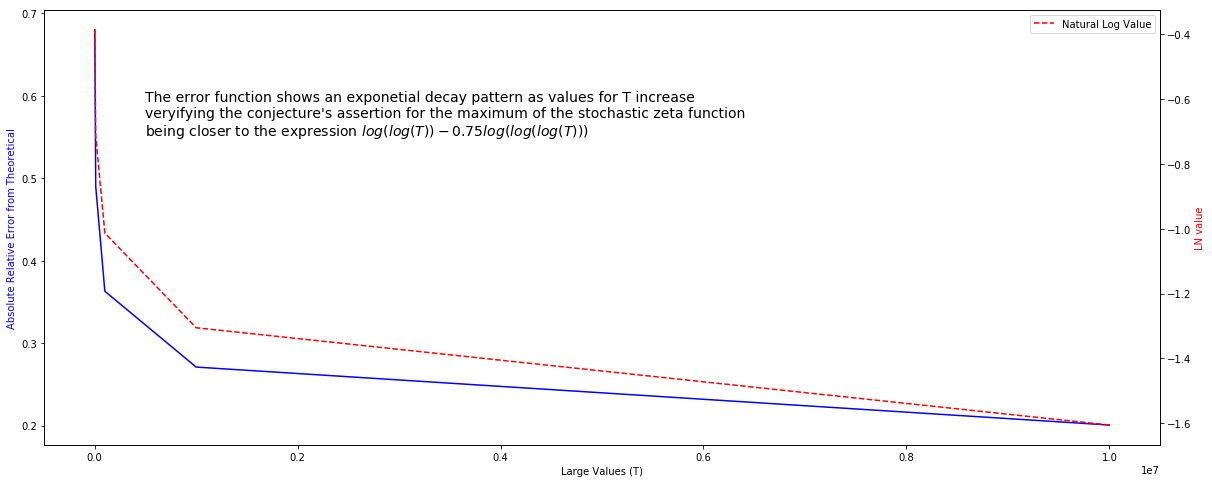

In [27]:
# shoot for 10^16 for prime list (finding relative error to ~5%)

fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(20)

ax1.set_xlabel('Large Values (T)')
ax1.set_ylabel('Absolute Relative Error from Theoretical', color='blue')
ax1.plot(time_range, error_arr, label='Error Decay', color='blue')

ax2 = ax1.twinx() 

ax2.plot(time_range, np.log(error_arr), color='red', label='Natural Log Value', ls='--')
ax2.set_ylabel('LN value', color='red')

# text componentes
ax1.text(500000, 0.55, 
         "The error function shows an exponetial decay pattern as values for T increase\nveryifying the conjecture's assertion for the maximum of the stochastic zeta function\nbeing closer to the expression $log(log(T)) - 0.75log(log(log(T)))$ ", 
         size=14, color='black')

plt.legend()
plt.show()

Taking our log of the error term, we can determine the approximate value of $T$ such that our relative error is bounded by $0.05$. This follows as such:
$$\epsilon = \frac{(\hat{max}_{|h|<1}X_t(h) - max_{|h|<1}X_t(h))}{max_{|h|<1}X_t(h)}$$
We take that as we increase the value for $T$ we take the natural log of the error function to be a proxy for the error decay rate. Hence, to find a appropriate value $T$ for the bounded $0.05$ condition we solve the expression below:

$$log(0.05)=x\Rightarrow x\approx-3$$

By simple extrapolation we have that at $\approx 10^{12}$ our relative error defined by $\epsilon$ above should converge to $\approx 0.05$. I show this relationship below, highlighting the linear relationship between the rise in $x$ and the fall in the natural log.  

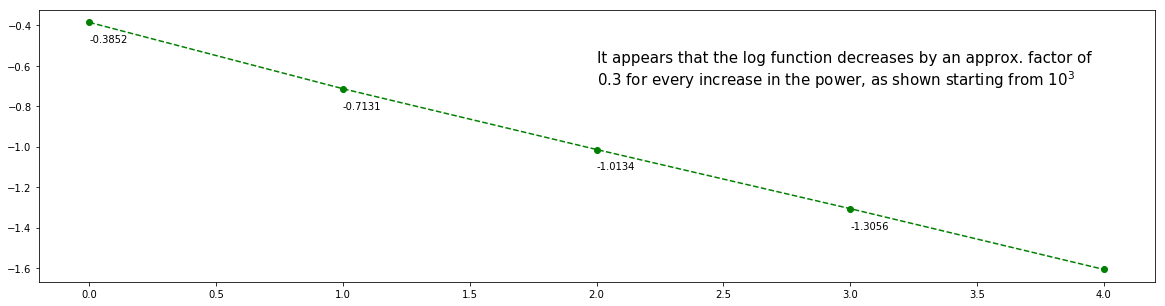

In [28]:
plt.figure(figsize=(20,5))
plt.text(2.0,-0.7,
         s='It appears that the log function decreases by an approx. factor of \n$0.3$ for every increase in the power, as shown starting from $10^3$',  
         size=15)
plt.plot(np.log(error_arr), color='green',  marker='o', ls='--')
for i in range(4):
    plt.text(i,np.log(error_arr)[i]-0.1,round(np.log(error_arr)[i], 4))
plt.show()

### Fyodorov-Hiary-Keating Conjecture

**Conjecture (Fyodorov-Hiary-Keating '12)**

if $\tau\sim Unif(T,2T)$, then as $T \rightarrow \infty$
$$max_{|h|<1}|\zeta(1/2 + i(\tau +h))| = \frac{log(T)}{log_2(T)^{3/4}}\cdot e^{M_t}$$
Where $M_t \rightarrow M$ in distribution and $P(M>y)\sim Cye^{-2y}$

**IID Heuristics predicts**
$$max_{|h|<1}|\zeta(1/2 + i(\tau +h))| = \frac{log(T)}{log_2(T)^{1/4}}\cdot e^{Gumbell}$$


In [29]:
%%cython
cimport numpy as nc

import pyximport
pyximport.install(pyimport=True)

from mpmath import zeta
from random import uniform

def zetaUniformNorm(int T, int h) -> double:
    """
    An itterative algorithm for computing the stochastic Zeta function defined X_t(h)
    :param N: Provide a number (presumably large) to start computing values for
    :param deltaN: Provide an integer number to cap off the consecutive sums of prime
    :return: Returns an array of the normalized values for Zeta 
    """
    cdef nc.complex128_t point = complex(0, 0)
    cdef double upper = 2 * T

    # computing the Zeta function for a single point h for a given T
    point = zeta(complex(real=0.5, imag=uniform(T, upper) + h))

    return abs(point)

In [30]:
# value of T placed at 10^7 (ideally taken should be taken 10^15, 10^25, etc)
T_uniform = int(1e7)

# create range interval of h from -1 to 1 (points at every 2π/log(T/2π))
x_uniform=np.arange(-1,1,(2*np.pi)/np.log(T_uniform/(2*np.pi)))

In [31]:
x_uniform

array([-1.        , -0.56000776, -0.12001553,  0.31997671,  0.75996894])

In [32]:
uniform_sims = 100
uniform_zeta = np.array([[zetaUniformNorm(T=T_uniform, h=H) for H in x_uniform] for _ in range(uniform_sims)])

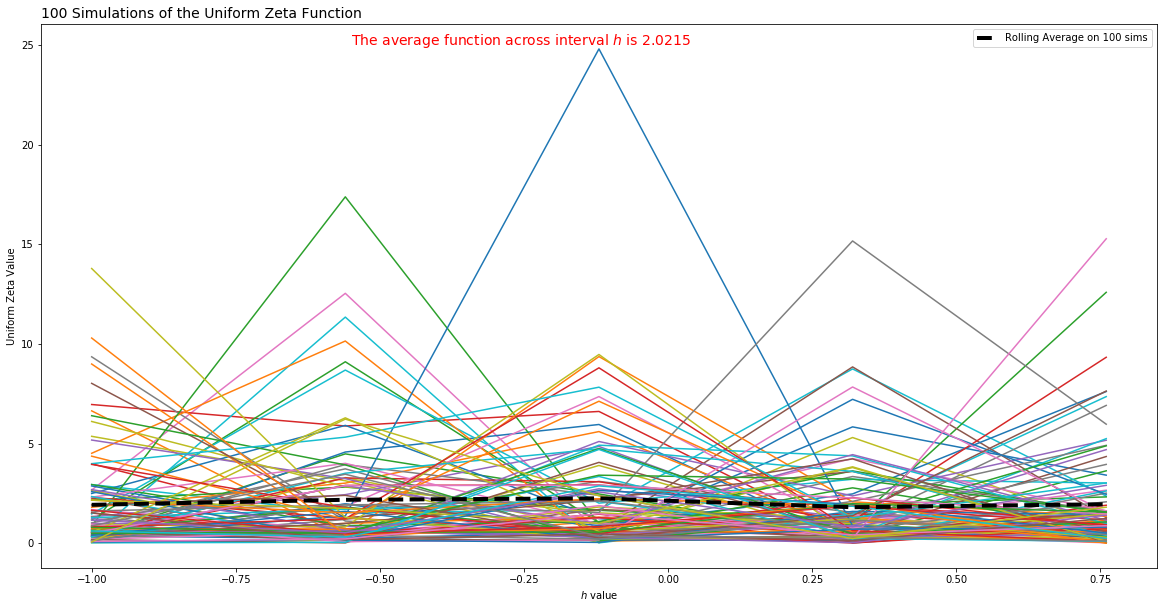

In [33]:
plt.figure(figsize=(20,10))  
plt.title("{} Simulations of the Uniform Zeta Function".format(uniform_sims), loc='left', size=14)
for i in uniform_zeta:
    plt.plot(x_uniform, i)
plt.plot(x_uniform, np.average(uniform_zeta, axis=0), lw=4, color='black', label='Rolling Average on {} sims'.format(uniform_sims), ls='--')
plt.text(-0.55, 25, 
         "The average function across interval $h$ is {}".format(round(np.average(np.average(uniform_zeta, axis=0)), 4)), 
         size=14, color='red')

plt.ylabel('Uniform Zeta Value')
plt.xlabel('$h$ value')
plt.legend()
plt.show()

In [34]:
# computes the max of the uniform zeta function 
uniform_max_fhk1 = lambda x: (np.log(x) /  (np.log(np.log(x))**0.75)) * np.exp(np.average(gumbel_r.rvs(loc=0, scale=0.5, size=1000)))

uniform_max_iid1 = lambda x: (np.log(x) /  (np.log(np.log(x))**0.25)) * np.exp(np.average(gumbel_r.rvs(loc=0, scale=0.5, size=1000)))

uniform_max_fhk2 = lambda x: (np.log(x) /  (np.log(np.log(x))**0.75)) * np.exp(-np.average(gumbel_r.rvs(loc=0, scale=0.5, size=1000)))

uniform_max_iid2 = lambda x: (np.log(x) /  (np.log(np.log(x))**0.25)) * np.exp(-np.average(gumbel_r.rvs(loc=0, scale=0.5, size=1000)))

In [63]:
# determining the conjecture maxes defined above
cong_iid_max = uniform_max_iid1(T_uniform)
cong_fhk_max = uniform_max_fhk1(T_uniform)

print('Implementanting an exponential Gumbel')
print("Our simulated maximum was        ->", np.average(uniform_zeta.max(axis=1)))
print("FHK Conjecture maximum should be ->", cong_fhk_max)
print("IID Conjecture maximum should be ->", cong_iid_max)

print()

# modifying the conjectures with a negative component 
cong_iid_max = uniform_max_iid2(T_uniform)
cong_fhk_max = uniform_max_fhk2(T_uniform)

print('Implementanting a negative exponential Gumbel')
print("Our simulated maximum was        ->", np.average(uniform_zeta.max(axis=1)))
print("FHK Conjecture maximum should be ->", cong_fhk_max)
print("IID Conjecture maximum should be ->", cong_iid_max)

Implementanting an exponential Gumbel
Our simulated maximum was        -> 5.434089102507306
FHK Conjecture maximum should be -> 9.755321115999147
IID Conjecture maximum should be -> 16.62268303476283

Implementanting a negative exponential Gumbel
Our simulated maximum was        -> 5.434089102507306
FHK Conjecture maximum should be -> 5.837718941716729
IID Conjecture maximum should be -> 9.533654562545552


Reflecting on the maximum conjecture for the Gumbel distribution it appears that the negative exponetial term appears to be in line with our simulated maximum. This is expressed below:
$$max_{|h|<1}|\zeta(1/2 + i(\tau +h))| = \frac{log(T)}{log_2(T)^{3/4}}\cdot e^{-M_t}$$

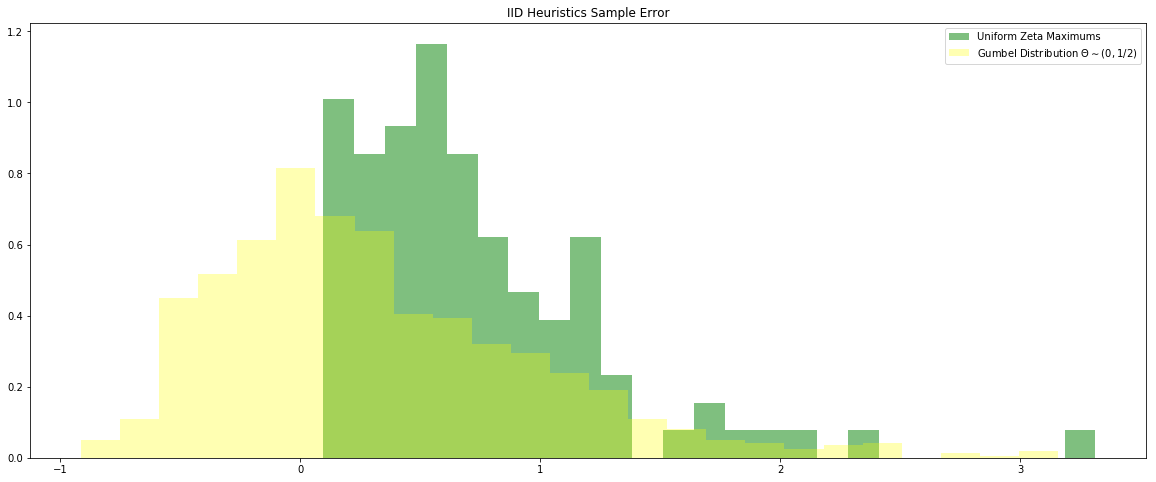

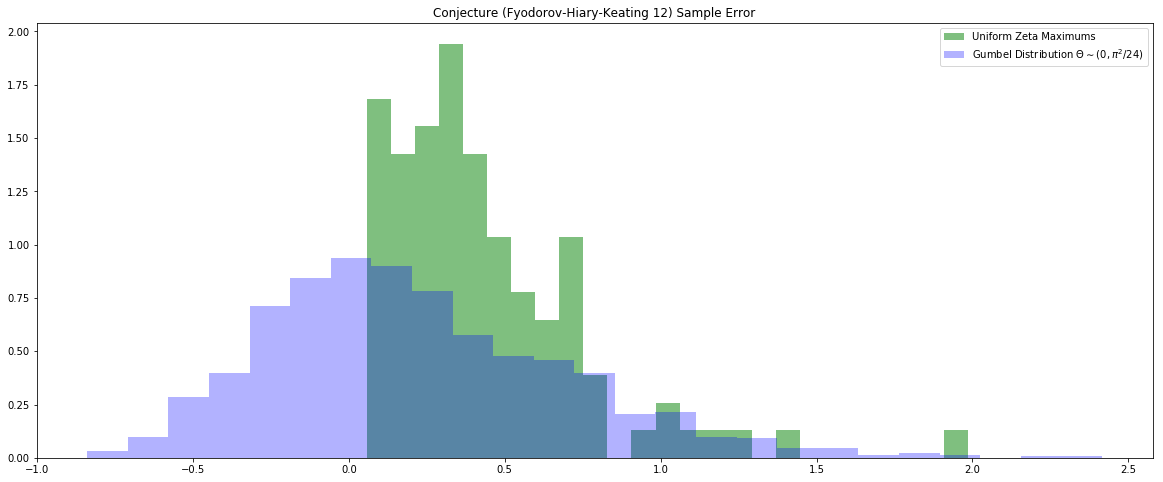

In [42]:
bins = 25
error1 = (uniform_zeta.max(axis=1) / (np.log(T_uniform) /  (np.log(np.log(T_uniform))**0.75)))
error2 = (uniform_zeta.max(axis=1) / (np.log(T_uniform) /  (np.log(np.log(T_uniform))**0.25)))
# examine evolution of T


# re-centered Gumbel distrubtion to observe the shape of the hist (variance 1/2)
plt.figure(figsize=(20, 8))
plt.title('IID Heuristics Sample Error')
plt.hist(error1, bins=bins, alpha=0.5, color='green', density=True, 
         label="Uniform Zeta Maximums") 
plt.hist(gumbel_r.rvs(loc=0, scale=0.5, size=1000), bins=bins, alpha=0.3, color='yellow', 
         label="Gumbel Distribution $\Theta \sim (0,1/2)$", density=True)
plt.legend()
plt.show()

# re-centered Gumbel distrubtion to observe the shape of the hist (variance pi^2/24)
plt.figure(figsize=(20, 8))
plt.title('Conjecture (Fyodorov-Hiary-Keating 12) Sample Error')
plt.hist(error2, bins=bins, alpha=0.5, color='green', density=True, 
         label="Uniform Zeta Maximums") 
plt.hist(gumbel_r.rvs(loc=0, scale=(np.pi**2)/24, size=1000), bins=bins, alpha=0.3, color='blue', 
         label="Gumbel Distribution $\Theta \sim (0,\pi^2/24)$", density=True)
plt.legend()
plt.show()

In [43]:
print(np.var(error1), np.var(error2))

0.2850116840045318 0.10252430556968527


In [44]:
np.average(error1), np.average(error2)

(0.7258383279412012, 0.43533339475556426)

In [39]:
np.var(gumbel_r.rvs(loc=0, scale=0.5, size=10000))

0.4162536939602046